In [35]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e12/sample_submission.csv
/kaggle/input/playground-series-s4e12/train.csv
/kaggle/input/playground-series-s4e12/test.csv


In [36]:
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from catboost import CatBoostRegressor

In [119]:
df = pd.read_csv("/kaggle/input/playground-series-s4e12/train.csv")
# df.head()

In [ ]:
df_test = pd.read_csv("/kaggle/input/playground-series-s4e12/test.csv")
df_test.head()

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object 
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            841925 non-null   object 
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-

In [120]:
df.describe().round(1)

,id,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount
count,1200000.0,1181295.0,1155051.0,1090328.0,1125924.0,835971.0,1199994.0,1062118.0,1199999.0,1200000.0
mean,599999.5,41.1,32745.2,2.0,25.6,1.0,9.6,592.9,5.0,1102.5
std,346410.3,13.5,32179.5,1.4,12.2,1.0,5.8,150.0,2.6,865.0
min,0.0,18.0,1.0,0.0,2.0,0.0,0.0,300.0,1.0,20.0
25%,299999.8,30.0,8001.0,1.0,15.9,0.0,5.0,468.0,3.0,514.0
50%,599999.5,41.0,23911.0,2.0,24.6,1.0,10.0,595.0,5.0,872.0
75%,899999.2,53.0,44634.0,3.0,34.5,2.0,15.0,721.0,7.0,1509.0
max,1199999.0,64.0,149997.0,4.0,59.0,9.0,19.0,849.0,9.0,4999.0


In [ ]:
df.isna().sum()

In [ ]:
sns.heatmap(df.isna().sort_values(by=["Occupation"]) == True)

In [47]:
for non_object_column in df.select_dtypes(exclude = "object").columns:
    print(df[non_object_column].mean())

599984.7646690074
41.14886689349543
32294.908372535545
2.0080732216586163
25.611307237793376
1.001807426925206
9.580239824169794
591.4949320974465
5.019516994274517
1098.6865405005199


In [66]:
for non_object_column in df.select_dtypes(exclude = "object").columns:
    if non_object_column != 'id':
        print(df[non_object_column].mode()[0])

61.0
32745.21777653108
3.0
25.613907692519252
1.002689088497089
17.0
592.9243502134415
9.0
25.0


In [65]:
df['Age'].mode()[0]

61.0

In [68]:
# df.dropna(inplace = True)
for non_object_column in df.select_dtypes(exclude = "object").columns:
    df[non_object_column].fillna(df[non_object_column].mode()[0], inplace = True)

df.dropna(inplace = True)

In [69]:
df.shape

(775274, 21)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(df.select_dtypes(exclude = "object").corr(), annot = True, cmap = "Reds")

In [ ]:
df_categorical = df.select_dtypes('object')
for object_column in df_categorical.columns:
    print(object_column, {df[object_column].nunique()}, ': ', df[object_column].unique(), '\n')

In [70]:
df.drop(['id', 'Policy Start Date'], axis = 1, inplace = True)

In [ ]:
for non_object_column in df.select_dtypes(exclude = "object").columns:
    if non_object_column != 'Premium Amount':
        df[non_object_column] = df[non_object_column] / df[non_object_column].max()

In [ ]:
df.head()

In [ ]:
df["Policy Start Date"] = pd.to_datetime(df["Policy Start Date"].apply(lambda x: x[:10]))

In [ ]:
pd.get_dummies(df_categorical, drop_first = True, dtype = int)

In [71]:
df = pd.concat(
    [
        df.select_dtypes(exclude = "object"), 
        pd.get_dummies(df.select_dtypes('object'), drop_first = True, dtype = int)
    ],
    axis = "columns"
)
df.head()

,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount,Gender_Male,...,Policy Type_Comprehensive,Policy Type_Premium,Customer Feedback_Good,Customer Feedback_Poor,Smoking Status_Yes,Exercise Frequency_Monthly,Exercise Frequency_Rarely,Exercise Frequency_Weekly,Property Type_Condo,Property Type_House
0,19.0,10049.0,1.0,22.598761,2.0,17.0,372.0,5.0,2869.0,0,...,0,1,0,1,0,0,0,1,0,1
2,23.0,25602.0,3.0,47.177549,1.0,14.0,434.0,3.0,567.0,1,...,0,1,1,0,1,0,0,1,0,1
4,21.0,39651.0,1.0,20.376094,0.0,8.0,598.0,4.0,2022.0,1,...,0,1,0,1,1,0,0,1,0,1
7,48.0,127237.0,2.0,5.769783,1.0,11.0,398.0,5.0,111.0,0,...,1,0,0,0,0,0,1,0,1,0
9,44.0,52447.0,2.0,20.473718,1.0,9.0,635.0,3.0,64.0,1,...,1,0,0,1,0,0,0,0,1,0


In [72]:
df.to_csv("train_new.csv", index=False)

In [32]:
df = pd.read_csv("/kaggle/working/train_new.csv")

In [ ]:
df.dtypes

In [ ]:
df.describe()

{'whiskers': [<matplotlib.lines.Line2D at 0x7d83697671c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7d8369765a50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7d8369ea1f90>],
 'medians': [<matplotlib.lines.Line2D at 0x7d8369767b50>],
 'fliers': [<matplotlib.lines.Line2D at 0x7d83697678b0>],
 'means': []}

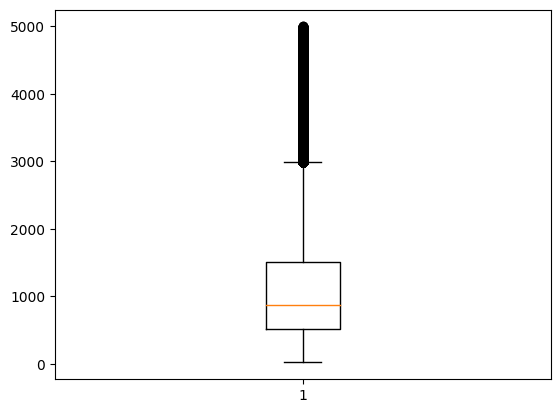

In [73]:
plt.boxplot(df['Premium Amount'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7d83693548b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7d8369354df0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7d8369354610>],
 'medians': [<matplotlib.lines.Line2D at 0x7d8369355330>],
 'fliers': [<matplotlib.lines.Line2D at 0x7d83693555d0>],
 'means': []}

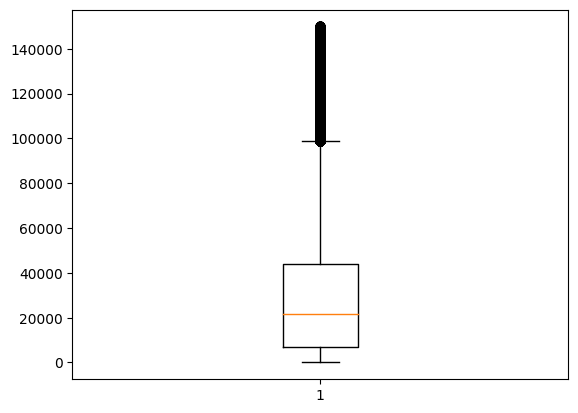

In [74]:
plt.boxplot(df['Annual Income'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7d832a295420>,
 'caps': [<matplotlib.lines.Line2D at 0x7d832a295960>,
 'boxes': [<matplotlib.lines.Line2D at 0x7d832a295180>],
 'medians': [<matplotlib.lines.Line2D at 0x7d832a295ea0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7d832a296140>],
 'means': []}

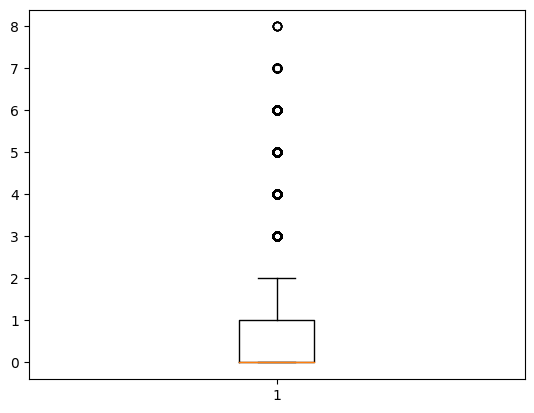

In [75]:
plt.boxplot(df['Previous Claims'])

In [ ]:
df[df['Previous Claims'] > 2]['Age'].count()

In [ ]:
df[df['Annual Income'] > 100_000]['Age'].count()

In [30]:
df[(df['Previous Claims'] > 2) | (df['Annual Income'] > 100_000) | (df['Premium Amount'] > 3000)]['Age'].count()

61596

In [ ]:
df['Age'].count()

In [34]:
df2 = df[(df['Previous Claims'] > 2) | (df['Annual Income'] > 100_000) | (df['Premium Amount'] > 3_000)]
df2['Age'].count()

24118

In [85]:
df = df[(df['Previous Claims'] <= 5) & (df['Annual Income'] <= 100_000) & (df['Premium Amount'] <= 3000)]
df['Age'].count()

704806

In [86]:
x = df.drop(['Premium Amount'], axis = 1)
y = df['Premium Amount']

In [87]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

In [78]:
model1 = LinearRegression()
model2 = RandomForestRegressor(n_estimators=28, random_state=0)
model3 = PolynomialFeatures(degree=4)
model4 = CatBoostRegressor(
                            # iterations=1000,
                            learning_rate=0.01,
                            depth = 7,
                            n_estimators = 1000,
                            verbose = False
)
model4_2 = CatBoostRegressor(
                            # iterations=1000,
                            learning_rate=0.01,
                            depth = 7,
                            n_estimators = 1000,
                            verbose = False
)

In [ ]:
x_train = model3.fit_transform(x_train)
x_test = model3.fit_transform(x_test)
x = model3.fit_transform(x)

In [88]:
# model = model3
# model.fit(model3.fit_transform(x_train))

# model = model1
# model.fit(model3.fit(model3.fit_transform(x_train)), y_train)

model = model4
model.fit(x_train, y_train)

In [89]:
y_pred = model.predict(x_test)

In [90]:
def rmsle(predictions, targets):
    """Calculate the root mean squared logarithmic error between predictions and targets"""
    return np.sqrt(np.mean((np.log(predictions + 1) - np.log(targets + 1)) ** 2))

In [91]:
df_pred = pd.DataFrame([y_pred, y_test]).transpose()
df_pred = df_pred.describe()
df_pred['diff'] = df_pred[0] - df_pred[1]
df_pred['0/1'] = df_pred[0] / df_pred[1]
df_pred

,0,1,diff,0/1
count,140962.000000,140962.000000,0.000000,1.000000
mean,997.151579,994.983584,2.167995,1.002179
std,139.802558,700.000359,-560.197802,0.199718
min,329.714735,20.000000,309.714735,16.485737
25%,988.914091,503.000000,485.914091,1.966032
50%,1007.310770,832.000000,175.310770,1.210710
75%,1043.888816,1391.000000,-347.111184,0.750459
max,1290.302643,3000.000000,-1709.697357,0.430101


<ipython-input-92-57f1de8a0ccb>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


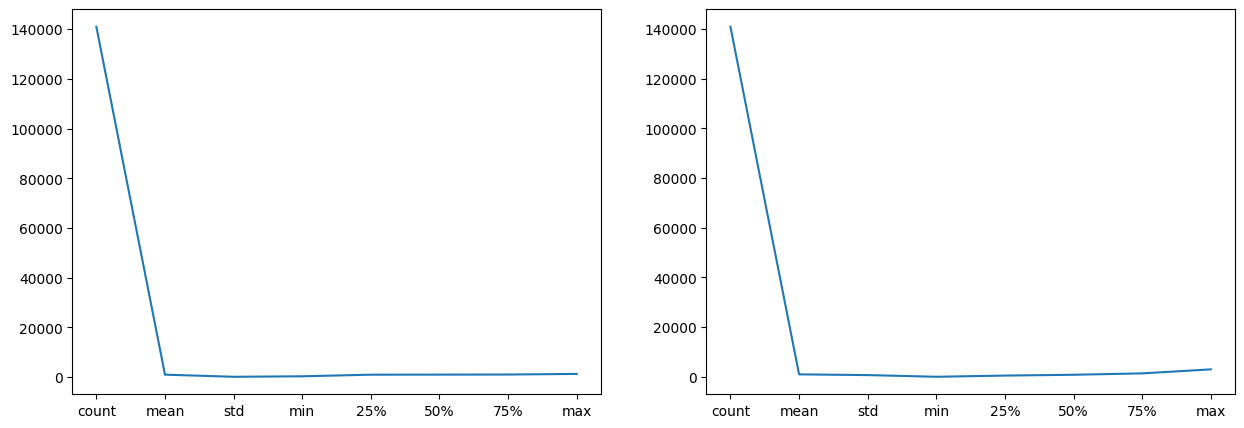

In [92]:
fig, ax = plt.subplots(figsize=(15, 5), sharey=True)
plt.subplot(1, 2, 1)
plt.plot(df_pred[0][:1000])
plt.subplot(1, 2, 2)
plt.plot(df_pred[1][:1000])

In [93]:
rmsle(y_pred, y_test)

1.0844906300051183

In [102]:
rmsle(y_pred-200, y_test)

1.0279940816174864

In [103]:
model.fit(x, y)

In [104]:
df_test = pd.read_csv("/kaggle/input/playground-series-s4e12/test.csv")

# for non_object_column in df_test.select_dtypes(exclude = "object").columns:
#     df_test[non_object_column] = df_test[non_object_column] / df_test[non_object_column].max()

for non_object_column in df_test.select_dtypes(exclude = "object").columns:
    df_test[non_object_column].fillna(df_test[non_object_column].mean(), inplace = True)

df_test["Policy Start Date"] = pd.to_datetime(df_test["Policy Start Date"].apply(lambda x: x[:10]))

df_test = pd.concat(
    [
        df_test.select_dtypes(exclude = "object"), 
        pd.get_dummies(df_test.select_dtypes('object'), drop_first = True, dtype = int)
    ],
    axis = "columns"
)

x_df_test = df_test.drop(['id', 'Policy Start Date'], axis = 1)

x2_df_test = x_df_test[(x_df_test['Previous Claims'] > 2) | (x_df_test['Annual Income'] > 100_000)]

# x_df_test = x_df_test[(x_df_test['Previous Claims'] <= 2) & (x_df_test['Annual Income'] <= 100_000)]

print(x_df_test.shape)
print(x2_df_test.shape)
x_df_test.head()

(800000, 28)
(82513, 28)


,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Gender_Male,Marital Status_Married,...,Policy Type_Comprehensive,Policy Type_Premium,Customer Feedback_Good,Customer Feedback_Poor,Smoking Status_Yes,Exercise Frequency_Monthly,Exercise Frequency_Rarely,Exercise Frequency_Weekly,Property Type_Condo,Property Type_House
0,28.0,2310.0,4.0,7.657981,1.004873,19.0,592.904749,1.0,0,0,...,0,0,0,1,1,0,0,1,0,1
1,31.0,126031.0,2.0,13.381379,1.004873,14.0,372.000000,8.0,0,1,...,0,1,1,0,1,0,1,0,0,0
2,47.0,17092.0,0.0,24.354527,1.004873,16.0,819.000000,9.0,0,0,...,1,0,0,0,1,1,0,0,1,0
3,28.0,30424.0,3.0,5.136225,1.000000,3.0,770.000000,5.0,0,0,...,1,0,0,1,1,0,0,0,0,1
4,24.0,10863.0,2.0,11.844155,1.004873,14.0,755.000000,7.0,1,0,...,0,1,0,0,0,0,0,1,0,1


In [ ]:
df_test[(df_test['Previous Claims'] > 2) | (df_test['Annual Income'] > 100_000)]['Age'].count()

In [115]:
Y_pred_test = model.predict(x_df_test)

In [ ]:
x2 = df2.drop(['Premium Amount'], axis = 1)
y2 = df2['Premium Amount']
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size = 0.2, random_state = 1)
model_2 = model4_2
model_2.fit(x2_train, y2_train)
y2_pred = model_2.predict(x2_test)

df2_pred = pd.DataFrame([y2_pred, y2_test]).transpose()
df2_pred = df2_pred.describe()
df2_pred['diff'] = df2_pred[0] - df2_pred[1]
df2_pred['0/1'] = df2_pred[0] / df2_pred[1]
df2_pred

In [ ]:
print(rmsle(y2_pred, y2_test))

In [ ]:
print(rmsle(y2_pred-401.5, y2_test))

In [ ]:
model4_2 = CatBoostRegressor(
                            # iterations=1000,
                            learning_rate=0.01,
                            depth = 9,
                            n_estimators = 1000,
                            verbose = False
)
model_2 = model4_2
model_2.fit(x2, y2)

In [ ]:
Y2_pred_test = model_2.predict(x2_df_test)

In [ ]:
Y_pred_test.size + Y2_pred_test.size

In [ ]:
df_sub = pd.read_csv("/kaggle/input/playground-series-s4e12/sample_submission.csv")
df_sub.head()

In [116]:
Y_pred_test = Y_pred_test - 100

# Y2_pred_test = Y2_pred_test - 401.5

In [ ]:
x_df_test['Prediction'] = Y_pred_test

x2_df_test['Prediction'] = Y2_pred_test

Y_pred_test_result = pd.concat([x_df_test, x2_df_test], axis = 'rows')['Prediction'].sort_index()

In [ ]:
Y_pred_test_result.size

In [117]:
df_test['Premium Amount'] = Y_pred_test.round(3)
df_submission = df_test[['id', 'Premium Amount']]

print(df_submission.shape)
df_submission.head()

(800000, 2)


,id,Premium Amount
0,1200000,1105.151
1,1200001,902.570
2,1200002,889.430
3,1200003,918.852
4,1200004,872.753


In [118]:
df_submission.to_csv("submissions1.csv", index=False)

In [ ]:
df = df.sort_values(by='Premium Amount').reset_index(drop=True)
df

In [ ]:
plt.plot(df['Premium Amount'])